# Compare - Shanghai Composite Index

1. PAPER: [Financial Time Series Forecasting with the Deep Learning Ensemble Model](https://www.mdpi.com/2227-7390/11/4/1054) by He K., et al. 2023
2. NOTE (of stock data):
    1. **Raw Data** is mostly non-stationary.
    2. **Returns Data** is stationary and also called differenced.

In [1]:
import os
import sys
# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to the system path
sys.path.append(os.path.join(notebook_dir, '../tslearn/'))

from collections import namedtuple
from data_loader import build_stock_uts, build_downloaded_stock_uts
from time_series import TimeSeriesFactory
from data_plotter import InterpolatePlotter
from ts_models import AR_Model, MA_Model, ARMA, ARIMA_model, EvaluationMetric

## Stock Data: Analysis

1. Load Raw Data
2. Plot Raw Data
3. Get Descriptive Statistics (ie: mean, median, range, etc) of Raw Data
4. Check Stationarity of Raw Data
5. Plot Autocorrelation and Partial Autocorrelation of Raw Data
6. Get Returns Data
7. Plot Returns Data
8. Get Descriptive Statistics (ie: mean, median, range, etc) of Returns Data
9. Check Stationarity of Returns Data
10. Plot Autocorrelation and Partial Autocorrelation of Returns Data

## Stock Data: Models

11. Split Returns Data
12. Initialize Models: `AR(p)` and `ARMA(p, q)`
13. Split Raw Data
14. Initialize Model: `ARMA(p, d, q)`

## Stock Data: Evaluation Metrics + Plots

15. Evaluation Metrics `MSE`, `RMSE`
16. Plot Actual Predictions vs Model Predictions

## Follow-up

- Notes on above

## Stock Data: Analysis

### Load Raw Data

In [2]:
# Only grab stocks whose data is available for the entire time period
start_date, end_date = "2010-01-04", "2020-02-07"
Stock = namedtuple("Stock", ["symbol", "name"])
stocks = [
    ("000001.SS", "Shanghai Composite Index")
]
independent_variable = "Close"
# # frequency = 
stocks = [Stock(*s) for s in stocks]
stocks = {s.symbol: build_stock_uts(s.symbol, s.name, independent_variable, start_date=start_date, end_date=end_date, frequency='1d') for s in stocks}

[*********************100%***********************]  1 of 1 completed


In [3]:
values_cols = list(stocks.keys())
stock_mvts = TimeSeriesFactory.create_time_series(
    time_col="date",
    time_values=stocks[values_cols[0]].data.index,
    values_cols=values_cols,
    values=[stock.get_series() for stock in stocks.values()]
)

Len [2447]
Len [2447]


In [4]:
stock_symbol = '000001.SS'
stock_of_interest = stocks[stock_symbol]
type(stock_of_interest), stock_of_interest

(time_series.UnivariateTimeSeries, UnivariateTimeSeries(Close))

In [5]:
stock_df = stock_of_interest.get_as_df()
stock_df

,Close
Date,
2010-01-04,3243.760010
2010-01-05,3282.178955
2010-01-06,3254.215088
2010-01-07,3192.775879
2010-01-08,3195.997070
...,...
2020-01-23,2976.528076
2020-02-03,2746.605957
2020-02-04,2783.288086


### Plot Raw Data

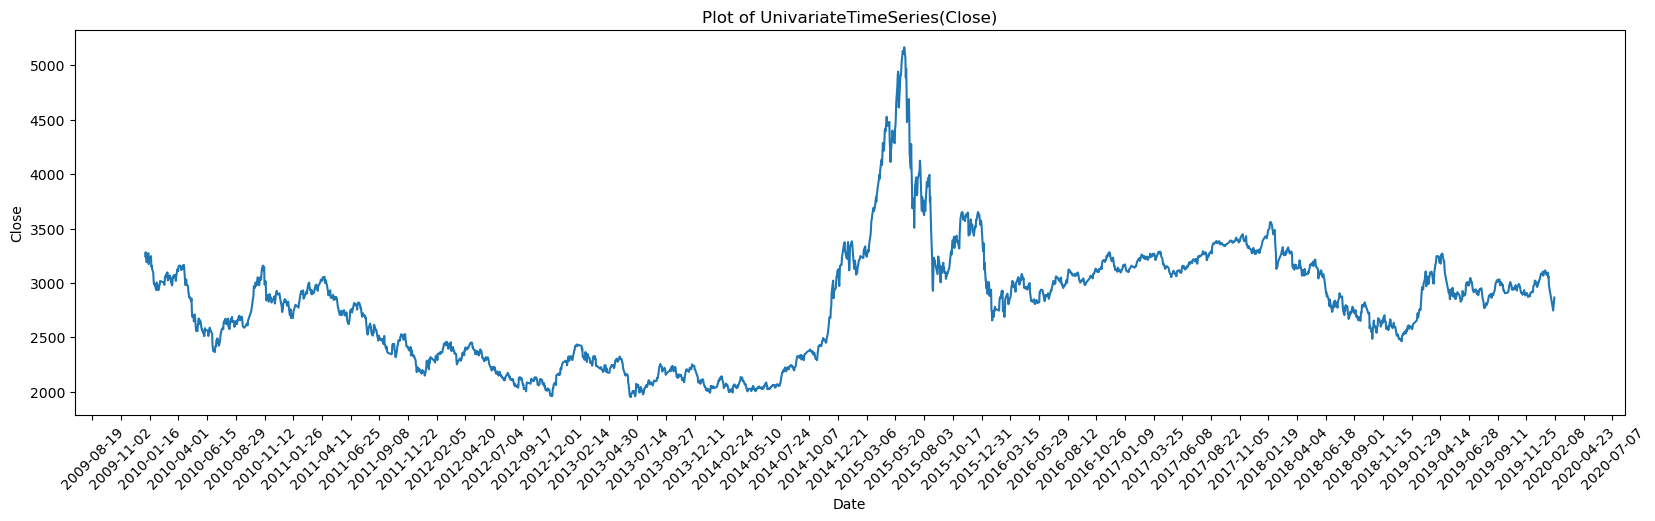

In [6]:
stock_of_interest.plot(tick_skip=75)

### Get Descriptive Statistics of Raw Data

In [7]:
stock_of_interest.get_statistics()

,Close
count,2447.000000
mean,2801.355809
std,529.298163
min,1950.011963
25%,2346.348389
50%,2859.758057
75%,3128.273560
max,5166.350098


In [8]:
stock_of_interest.range_skewness_kurtosis()

{'Range': Close    3216.338135
 dtype: float64,
 'Skewness': Close    0.748993
 dtype: float64,
 'Kurtosis': Close    1.537912
 dtype: float64}

### Check Stationarity of Raw Data

- With financial data, we expect it to be non-stationary (as in there's a change in either or both the mean of the variance between two distant points).

In [9]:
stock_of_interest.stationarity_test(stock_df)

ADF Statistic: -2.226796
p-value: 0.196664 > 0.05 , so accept the null-hypothesis as the TS is non-stationary
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


### Plot Autocorrelation and Partial Autocorrelation of Raw Data

- Not required for `AR` or `ARMA` models as both models assumes stationary and the TS is non-stationary.

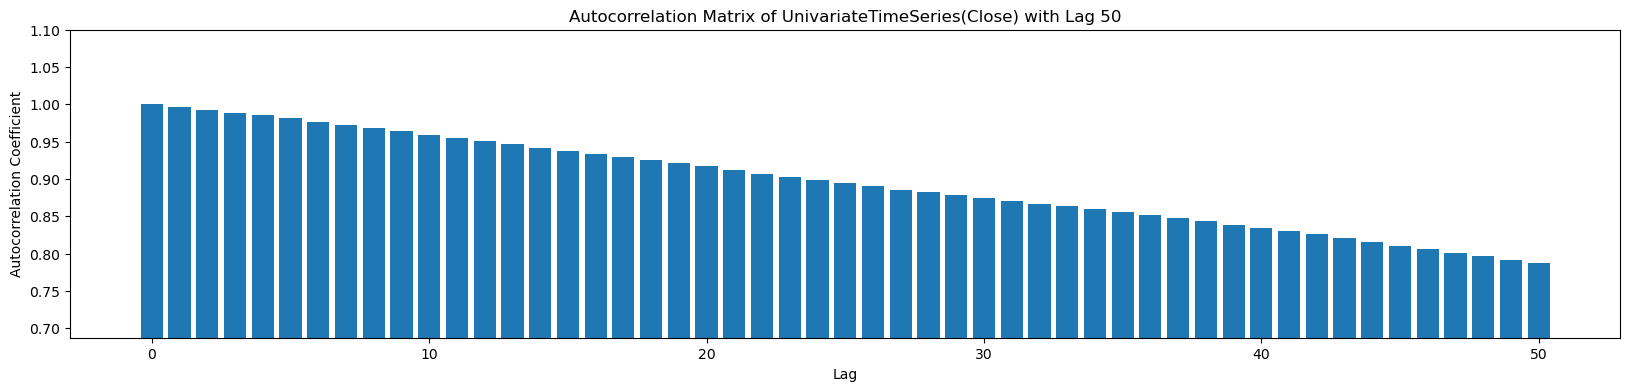

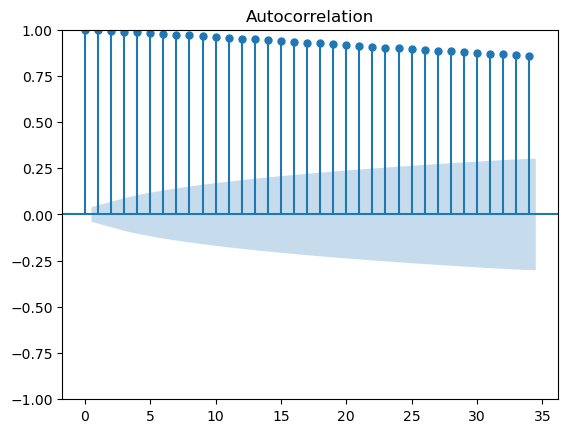

In [10]:
stock_of_interest.plot_autocorrelation(50)

- What is the above telling us?
    - Both plots are the same, just showing differently. 
    - Both plots confirm that the TS is non-stationary as in the current value depends on the previous value. We don't want this with traditional TS models like `AR`, `ARMA`.

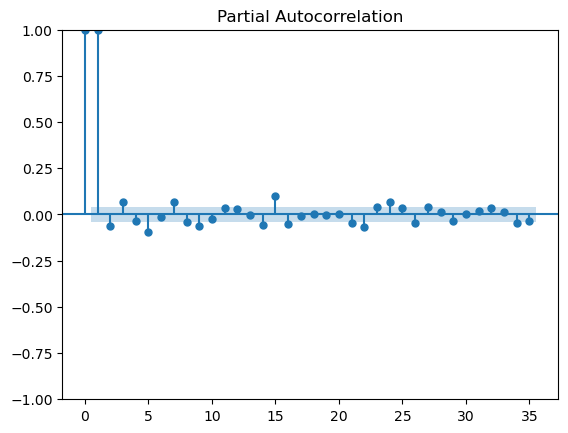

In [11]:
stock_of_interest.plot_partial_autocorrelation(35)

- What is the above telling us?
    - TS is non-stationary. Although data isn't as dependent (like the ACorr plot), the 1st is dependent upon the 0th. 

### Get Returns Data

- This should provide us with stationary data that we can pass to both `AR` and `ARMA` models.

In [12]:
len(stock_of_interest.get_series()), stock_of_interest.get_series()

(2447,
 array([3243.76000977, 3282.17895508, 3254.21508789, ..., 2783.28808594,
        2818.08789062, 2866.51000977]))

In [13]:
stock_returns = stock_of_interest.data_augment_for_returns()
stock_returns

UnivariateTimeSeries(Returns)

### Plot Returns

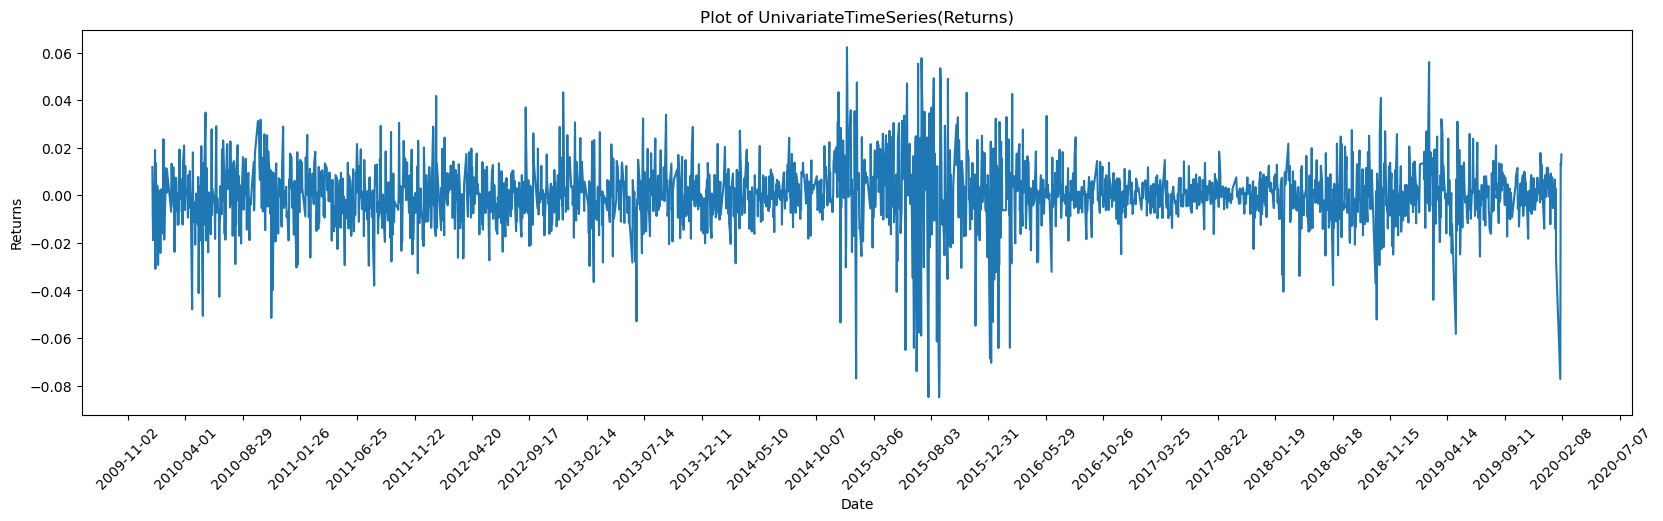

In [14]:
stock_returns.plot(tick_skip=150)

- Returns seem to have constant mean and constant variance although there are a few wide spread mean values between ~2014-10-07 to 2016-05-29 and ~2017-08-22 to 2019-04-14.

In [15]:
stock_returns_df = stock_returns.get_as_df()
stock_returns_df

,Returns
Date,
2010-01-05,0.011844
2010-01-06,-0.008520
2010-01-07,-0.018880
2010-01-08,0.001009
2010-01-11,0.005242
...,...
2020-01-23,-0.027518
2020-02-03,-0.077245
2020-02-04,0.013355


### Get Descriptive Statistics of Returns Data

In [16]:
stock_returns.get_statistics()

,Returns
count,2446.000000
mean,0.000043
std,0.013641
min,-0.084909
25%,-0.005829
50%,0.000502
75%,0.006362
max,0.062260


In [17]:
stock_returns.range_skewness_kurtosis()

{'Range': Returns    0.147169
 dtype: float64,
 'Skewness': Returns   -0.79317
 dtype: float64,
 'Kurtosis': Returns    5.834021
 dtype: float64}

### Check Stationarity of Returns Data

- Data is now stationary. Confirm with independence test which is only conducted on returns and has a null-hypothesis of data being independent (or not dependent).

In [18]:
stock_returns.stationarity_test(stock_returns_df)

ADF Statistic: -9.604483
p-value: 0.000000 < 0.05 , so reject null-hypothesis as the TS is stationary
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [19]:
stock_returns.independence_test(stock_returns_df)

BDS Statistic: 8.084943
p-value: 0.000000 < 0.05 , so reject null-hypothesis as the differenced TS is independent and i.i.d.


### Plot Autocorrelation and Partial Autocorrelation of Returns Data

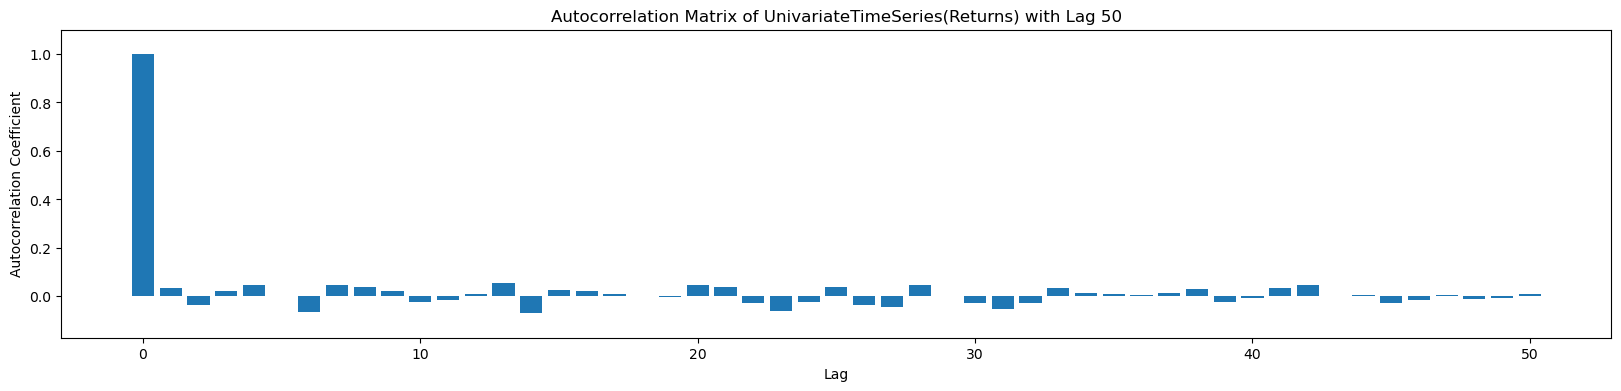

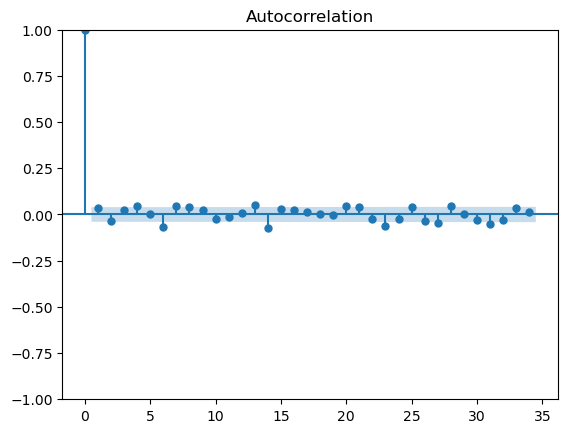

In [20]:
stock_returns.plot_autocorrelation(50)

- What is the above telling us?
    - Both plots are the same, just showing differently. 
    - Both plots confirm that the TS is stationary as in the current value doesn't depend on the previous value. This is what we want for `MA(q)`.
    - Lag exponentially decays at 1, thus use lag 1 for `MA(q)` as they have in the PAPER.


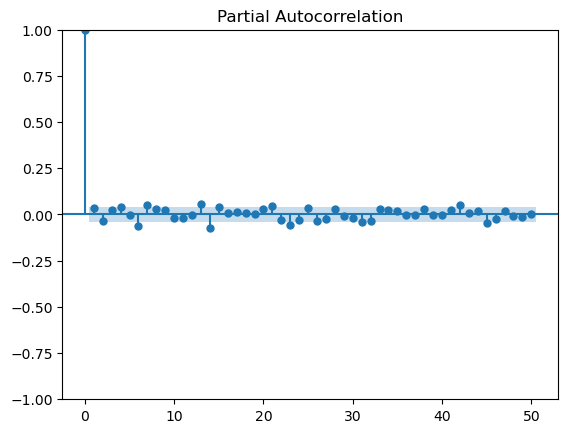

In [21]:
stock_returns.plot_partial_autocorrelation(50)

- What is the above telling us?
    - TS is stationary. The 1st is not dependent upon the 0th. This is what we want for `AR(p)`.
    - Lag exponentially decays at 1, thus use lag 1 for `AR(p)` as they have in the PAPER.

## Stock Data: Models

### Split Differenced Data for AR(p) and ARMA(p, q) Models

- Make 5-day forecasts

In [22]:
interpolation_step = 5
N = len(stock_returns.get_series())
diff_train_length = N - interpolation_step

In [23]:
diff_train_uts, diff_test_uts = stock_returns.get_slice(1, diff_train_length, both_train_test=True)
diff_train_uts, diff_test_uts

1 2441


(UnivariateTimeSeries(UnivariateTimeSeries(Returns)[1:2441]),
 UnivariateTimeSeries(UnivariateTimeSeries(Returns)[2441:2446]))

In [24]:
diff_train_df = diff_train_uts.get_as_df()
diff_train_df

,UnivariateTimeSeries(Returns)[1:2441]
Date,
2010-01-06,-0.008520
2010-01-07,-0.018880
2010-01-08,0.001009
2010-01-11,0.005242
2010-01-12,0.019054
...,...
2020-01-16,-0.005165
2020-01-17,0.000460
2020-01-20,0.006598


- Make 5-day forecasts, hence why test data is only 5 values.

In [25]:
diff_test_df = diff_test_uts.get_as_df()
diff_test_df

,UnivariateTimeSeries(Returns)[2441:2446]
Date,
2020-01-23,-0.027518
2020-02-03,-0.077245
2020-02-04,0.013355
2020-02-05,0.012503
2020-02-06,0.017183


### Initialize Model: AR(p)

In [26]:
lag_p = 1 # AR

In [27]:
diff_train_df

,UnivariateTimeSeries(Returns)[1:2441]
Date,
2010-01-06,-0.008520
2010-01-07,-0.018880
2010-01-08,0.001009
2010-01-11,0.005242
2010-01-12,0.019054
...,...
2020-01-16,-0.005165
2020-01-17,0.000460
2020-01-20,0.006598


In [28]:
diff_train_df.values

array([[-0.00851991],
       [-0.01887989],
       [ 0.0010089 ],
       ...,
       [ 0.00659764],
       [-0.01409891],
       [ 0.00282261]])

In [29]:
ar_model_class = AR_Model()
ar_model_class.train(diff_train_df.values, lag_p)
ar_model_class.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                 2440
Model:                     AutoReg(1)   Log Likelihood                7032.651
Method:               Conditional MLE   S.D. of innovations              0.014
Date:                Sun, 21 Jul 2024   AIC                         -14059.303
Time:                        21:16:28   BIC                         -14041.905
Sample:                             1   HQIC                        -14052.979
                                 2440                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.524e-05      0.000      0.238      0.812      -0.000       0.001
y.L1           0.0323      0.020      1.596      0.111      -0.007       0.072
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           30.9652           +0.0000j           30.9652            0.0000
-----------------------------------------------------------------------------
"""

In [30]:
# retrain false
ar_predictions_no_retrain = ar_model_class.make_predictions( diff_train_df, diff_test_df, False, lag_p)

# retrain true
ar_predictions_retrain = ar_model_class.make_predictions(diff_train_df, diff_test_df, True, lag_p)

ar_predictions_no_retrain, ar_predictions_retrain

(array([1.56396288e-04, 7.02927938e-05, 6.75121385e-05, 6.74223391e-05,
        6.74194391e-05]),
 [array([0.0001564]),
  array([-0.00082344]),
  array([-0.00242934]),
  array([0.00049655]),
  array([0.00046902])])

### Initialize Model: AR(q)

In [31]:
error_q = 1 # MA

ma_model_class = MA_Model(error_q)
ma_model_class.train(diff_train_df)
ma_model_class.summary()

/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:     UnivariateTimeSeries(Returns)[1:2441]   No. Observations:                 2440
Model:                                    ARIMA(0, 0, 1)   Log Likelihood                7035.928
Date:                                   Sun, 21 Jul 2024   AIC                         -14065.856
Time:                                           21:16:29   BIC                         -14048.457
Sample:                                                0   HQIC                        -14059.532
                                                  - 2440                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.271e-05      0.000      0.213      0.831      -0.001       0.001
ma.L1          0.0341      0.013      2.611      0.009       0.008       0.060
sigma2         0.0002   2.82e-06     64.918      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3359.91
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
# retrain false
ma_predictions_no_retrain = ma_model_class.make_predictions(diff_train_df, diff_test_df, False)

# retrain true
ma_predictions_retrain = ma_model_class.make_predictions(diff_train_df, diff_test_df, True)

ma_predictions_no_retrain, ma_predictions_retrain

/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


(2440    0.000173
 2441    0.000063
 2442    0.000063
 2443    0.000063
 2444    0.000063
 Name: predicted_mean, dtype: float64,
 [array([0.00015889]),
  array([-0.00087492]),
  array([-0.00256927]),
  array([0.00051777]),
  array([0.00048873])])

### Initialize Model: ARMA(p, q)

In [33]:
arma_model_class = ARMA(lag_p, error_q)
arma_model_class.train(diff_train_df)
arma_model_class.summary()

/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:     UnivariateTimeSeries(Returns)[1:2441]   No. Observations:                 2440
Model:                                    ARIMA(1, 0, 1)   Log Likelihood                7040.910
Date:                                   Sun, 21 Jul 2024   AIC                         -14075.820
Time:                                           21:16:29   BIC                         -14058.420
Sample:                                                0   HQIC                        -14069.495
                                                  - 2440                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9084      0.032    -27.966      0.000      -0.972      -0.845
ma.L1          0.9384      0.028     33.026      0.000       0.883       0.994
sigma2         0.0002   2.76e-06     66.107      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):              3269.70
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

NOTE: Should Dep. Variable be t as t depends on t - 1?

In [34]:
# retrain false
arma_predictions_no_retrain = arma_model_class.make_predictions(diff_train_df, diff_test_df, False)

# retrain true
arma_predictions_retrain = arma_model_class.make_predictions(diff_train_df, diff_test_df, True)
arma_predictions_no_retrain, arma_predictions_retrain

/Users/brinkley97/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


(2440    0.000211
 2441   -0.000192
 2442    0.000174
 2443   -0.000158
 2444    0.000144
 Name: predicted_mean, dtype: float64,
 [array([-0.90573527]),
  array([-0.93420612]),
  array([-0.98086796]),
  array([-0.89585163]),
  array([-0.89665141])])

In [35]:
len(diff_test_df), len(arma_predictions_no_retrain), len(arma_predictions_retrain)

(5, 5, 5)

### Split Raw Data for ARIMA(p, d, q) Model

- Make 5-day forecasts

In [ ]:
interpolation_step = 5
N = len(stock_of_interest.get_series())
train_length = N - interpolation_step
train_length

In [ ]:
train_uts, test_uts = stock_of_interest.get_slice(1, train_length, both_train_test=True)
train_uts, test_uts

In [ ]:
train_df = train_uts.get_as_df()
train_df

In [ ]:
test_df = test_uts.get_as_df()
test_df

### Initialize Models: ARIMA(p, d, q)

In [ ]:
diff_d = 1

arima_model_class = ARIMA_model()
arima_model_class

In [ ]:
trained_arima_model = arima_model_class.train_arima_model(train_df, lag_p, diff_d, error_q)
trained_arima_model

In [ ]:
trained_arima_model.summary()

In [ ]:
print('Coefficients: %s' % trained_arima_model.params)

In [ ]:
# retrain false
arima_predictions_no_retrain = arima_model_class.predict(trained_arima_model, train_df, test_df, False, lag_p)

# retrain true
arima_predictions_retrain = arima_model_class.predict(trained_arima_model, train_df, test_df, True, lag_p)

len(test_df), len(arima_predictions_no_retrain), len(arima_predictions_retrain)

## Stock Data: Evaluation Metrics + Plots

### Evaluation Metrics: MSE, RMSE

In [ ]:
# AR
EvaluationMetric.eval_mse(diff_test_df, ar_predictions_no_retrain, per_element=False)
EvaluationMetric.eval_rmse(diff_test_df, ar_predictions_no_retrain, per_element=False)
EvaluationMetric.eval_mse(diff_test_df, ar_predictions_retrain, per_element=False)
EvaluationMetric.eval_rmse(diff_test_df, ar_predictions_retrain, per_element=False)

# ARMA
EvaluationMetric.eval_mse(diff_test_df, arma_predictions_no_retrain, per_element=False)
EvaluationMetric.eval_rmse(diff_test_df, arma_predictions_no_retrain, per_element=False)
EvaluationMetric.eval_mse(diff_test_df, arma_predictions_retrain, per_element=False)
EvaluationMetric.eval_rmse(diff_test_df, arma_predictions_retrain, per_element=False)

# ARIMA
EvaluationMetric.eval_mse(diff_test_df, arima_predictions_no_retrain, per_element=False)
EvaluationMetric.eval_rmse(diff_test_df, arima_predictions_no_retrain, per_element=False)
EvaluationMetric.eval_mse(diff_test_df, arima_predictions_retrain, per_element=False)
EvaluationMetric.eval_rmse(diff_test_df, arima_predictions_retrain, per_element=False)

### Plots Actual Predictions vs Model Predictions
- Need to finish plots

In [ ]:
prediction_plots = InterpolatePlotter(diff_test_df, ar_predictions_no_retrain)
prediction_plots.plot_in_sample_predictions()

## Follow-up